In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders
from classes.model_pipeline import OptimalRegressionPipeline, OptimalClassificationPipeline
from classes.baseline_models import MeanBaselineModel, MajorityBaselineModel, RandomBaselineModel

import warnings
warnings.simplefilter('ignore')
load_dotenv();

In [111]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [112]:
df.head()

,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [113]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'genre']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']


---

# Regression

## Prediction with all features

In [56]:
target = 'popularity'
features = spotify_features + lyrics_features + tfidf_features + w2v_features + empath_features + audio_extracted_features

In [57]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [58]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'genre', 'language']

In [9]:
len(num_features)

457

In [10]:
pipeline = OptimalRegressionPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('preprocessor',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('num',
                                                                                                        Pipeline(steps=[('imputer',
                                                                                                                         SimpleImputer(strategy='median')),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['w2v_84',
                                                                                                         'empath_rural',
                                                                                                         'empath_power',
                                                                                                         'tfidf_88',
                                                                                                         'w2v_7',
                                                                                                         'empath_family',
                                                                                                         'w2v_61',
                                                                                                         'empath_kil...
                                                                                                        ['genre',
                                                                                                         'key',
                                                                                                         'explicit',
                                                                                                         'time_signature',
                                                                                                         'language',
                                                                                                         'mode'])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('feature_selection',
                                                                       SelectFromModel(estimator=RandomForestRegressor(random_state=42),
                                                                                       threshold='mean'))])),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x778c144b6710>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [11]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-19 23:58:16,322] A new study created in RDB with name: catboost_optimization_e1bbacd2-0a66-41fe-9215-731725d2ba65
[I 2024-12-19 23:58:31,251] Trial 5 finished with value: -0.24661898271644014 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.018618138278720928, 'l2_leaf_reg': 1.599621160729404}. Best is trial 5 with value: -0.24661898271644014.
[I 2024-12-19 23:58:31,555] Trial 1 finished with value: -0.22300333594732877 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.06782444135674366, 'l2_leaf_reg': 9.454304083902267}. Best is trial 1 with value: -0.22300333594732877.
[I 2024-12-19 23:58:46,214] Trial 9 finished with value: -0.27314812623528373 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.01336283012568003, 'l2_leaf_reg': 5.2364999667897685}. Best is trial 1 with value: -0.22300333594732877.
[I 2024-12-19 23:58:46,241] Trial 8 finished with value: -0.24208539651456912 and parameters: {'iterations': 500, 'depth': 4, 

INFO: Pipeline training completed.


In [12]:
pipeline.model.training_results

,Metric,Score
0,MAE,0.355
1,MSE,0.217
2,RMSE,0.466
3,R2,0.782


INFO: Evaluating the regression model...


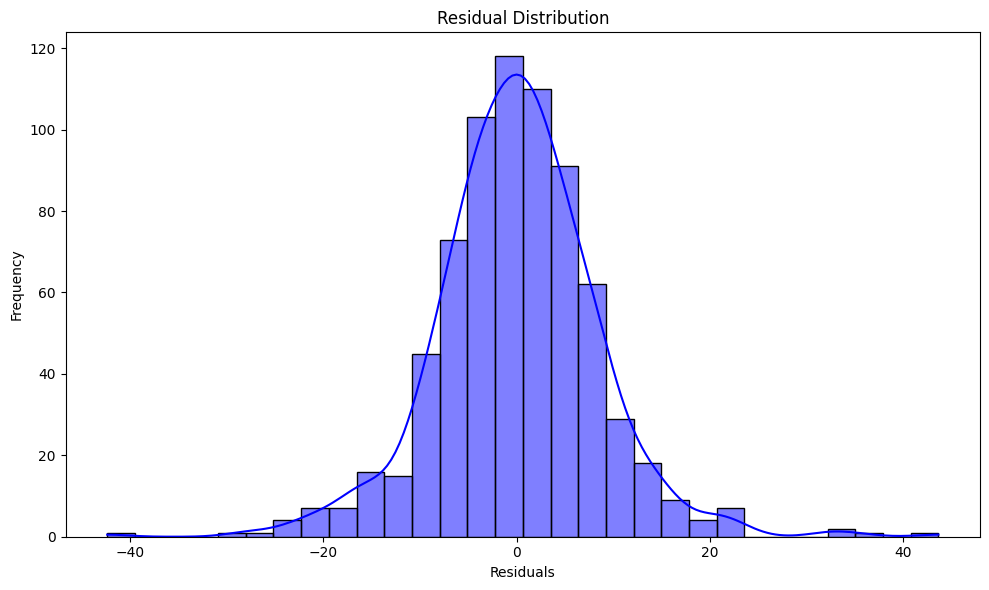

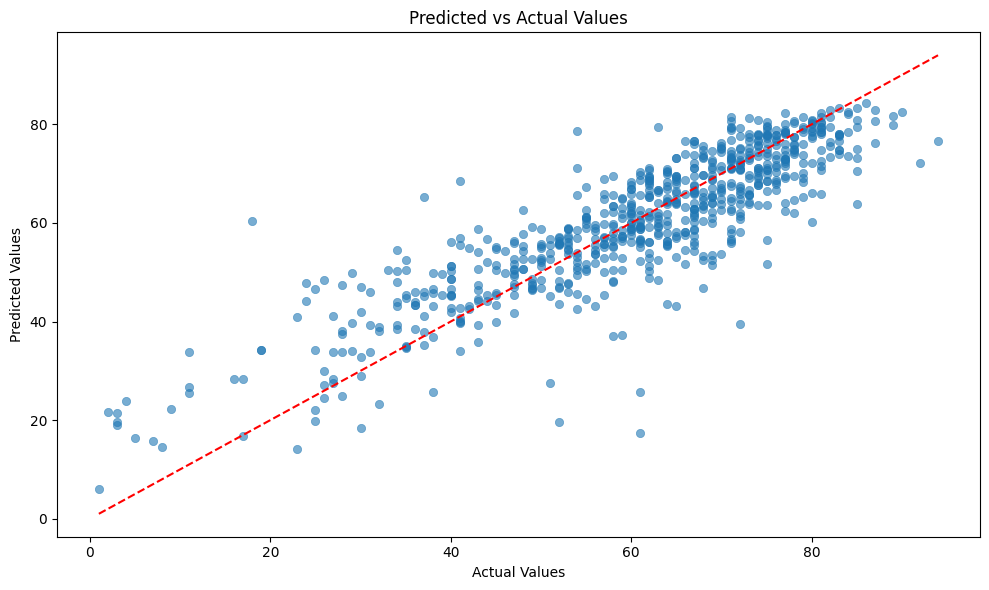

,Metric,Score
0,Mean Absolute Error,6.148604
1,Mean Squared Error,69.832890
2,Root Mean Squared Error,8.356608
3,R2 Score,0.752958


In [13]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


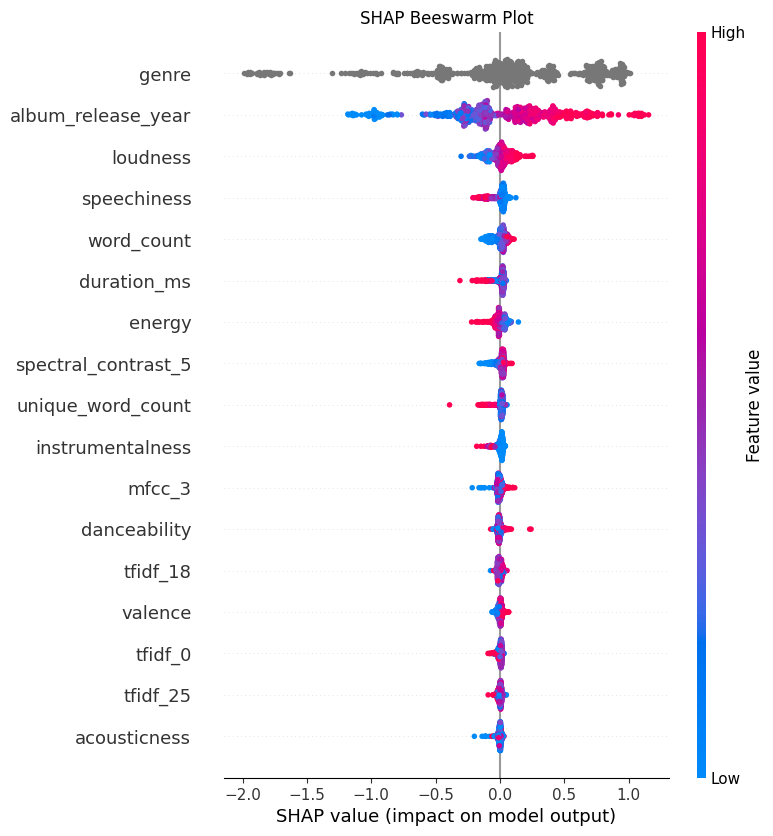

INFO: Generating feature importance bar plot...


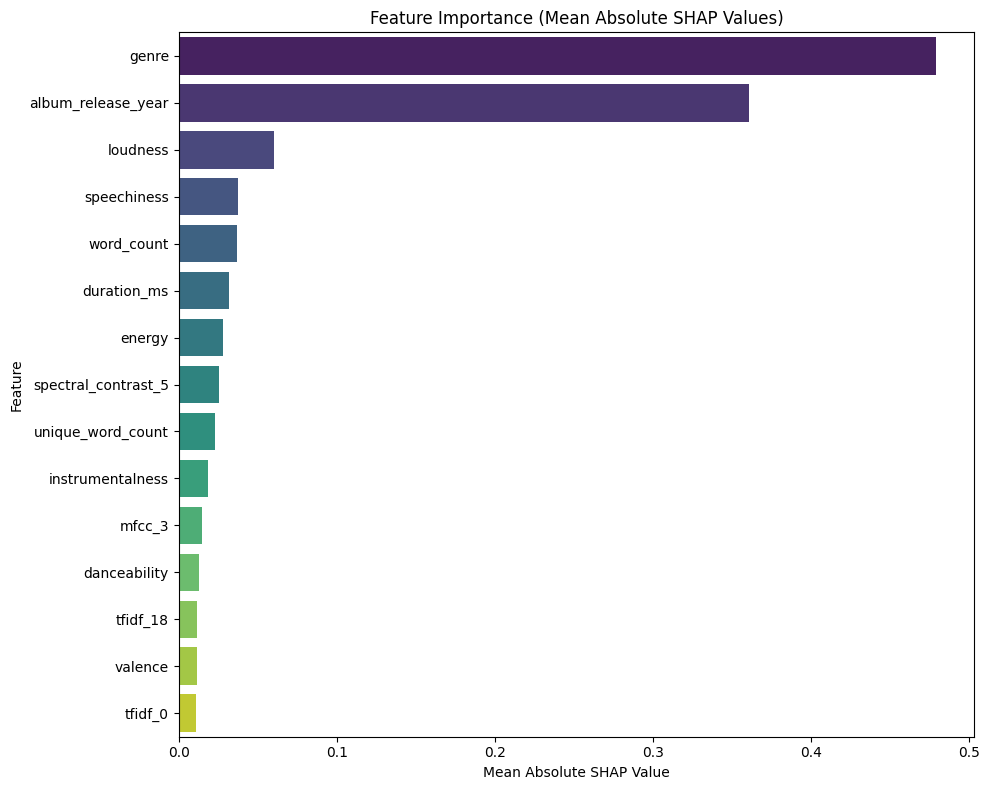

In [14]:
pipeline.perform_shap_analysis()

## Prediction with lyrics

In [59]:
target = 'popularity'
features = lyrics_features + tfidf_features + w2v_features + empath_features

In [60]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [61]:
cat_features

['language']

In [62]:
len(num_features)

412

In [63]:
pipeline = OptimalRegressionPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('preprocessor',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('num',
                                                                                                        Pipeline(steps=[('imputer',
                                                                                                                         SimpleImputer(strategy='median')),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['flesch_reading_ease',
                                                                                                         'w2v_62',
                                                                                                         'empath_power',
                                                                                                         'tfidf_48',
                                                                                                         'empath_medieval',
                                                                                                         'empath_swearing_te...
                                                                                                                                        handle_unknown='use_encoded_value',
                                                                                                                                        unknown_value=-1))]),
                                                                                                        ['language'])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('feature_selection',
                                                                       SelectFromModel(estimator=RandomForestRegressor(random_state=42),
                                                                                       threshold='mean'))])),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x7e07ed0cfdc0>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [64]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-20 14:32:47,031] A new study created in RDB with name: catboost_optimization_b742100e-5ca4-4244-9f05-8fdb783f2b01
[I 2024-12-20 14:36:24,755] Trial 3 finished with value: -0.7690817597710524 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.03925027953287898, 'l2_leaf_reg': 8.400251969967943}. Best is trial 3 with value: -0.7690817597710524.
[I 2024-12-20 14:36:43,886] Trial 0 finished with value: -0.7772401945568759 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.019365376886569505, 'l2_leaf_reg': 5.920636714912347}. Best is trial 3 with value: -0.7690817597710524.
[I 2024-12-20 14:36:51,497] Trial 2 finished with value: -0.7662274307941299 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.03855079332489224, 'l2_leaf_reg': 9.90782204190422}. Best is trial 2 with value: -0.7662274307941299.
[I 2024-12-20 14:36:51,536] Trial 1 finished with value: -0.7841231117383725 and parameters: {'iterations': 500, 'depth': 6, 'learnin

INFO: Pipeline training completed.


In [65]:
pipeline.model.training_results

,Metric,Score
0,MAE,0.683
1,MSE,0.764
2,RMSE,0.874
3,R2,0.235


INFO: Evaluating the regression model...


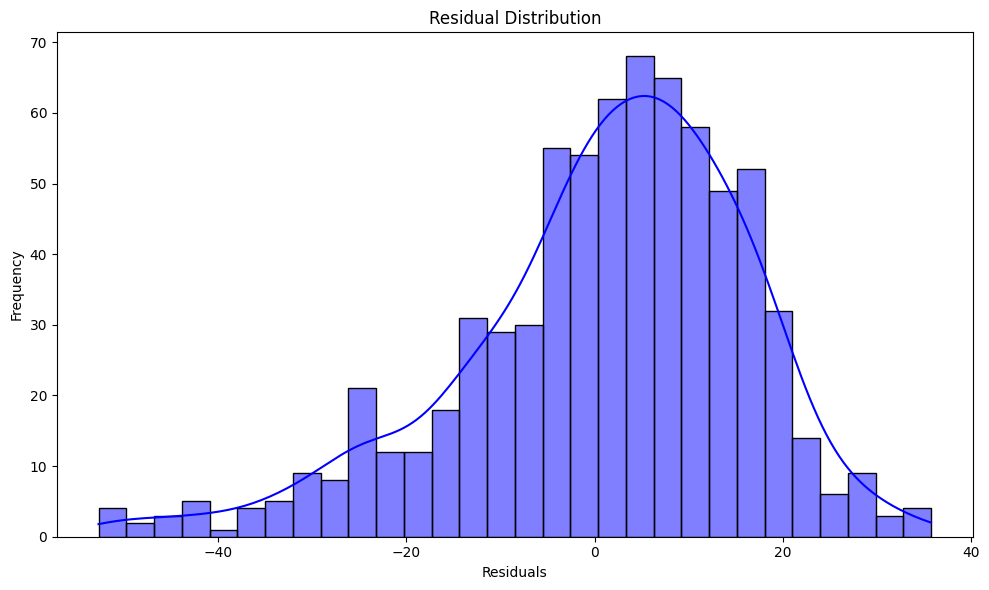

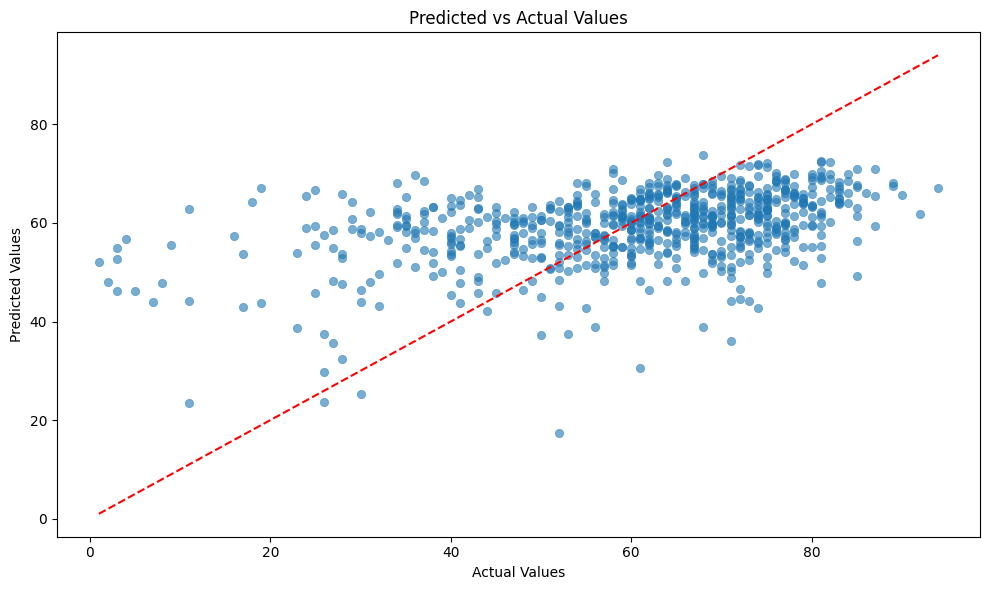

,Metric,Score
0,Mean Absolute Error,11.907140
1,Mean Squared Error,234.296914
2,Root Mean Squared Error,15.306760
3,R2 Score,0.171147


In [66]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


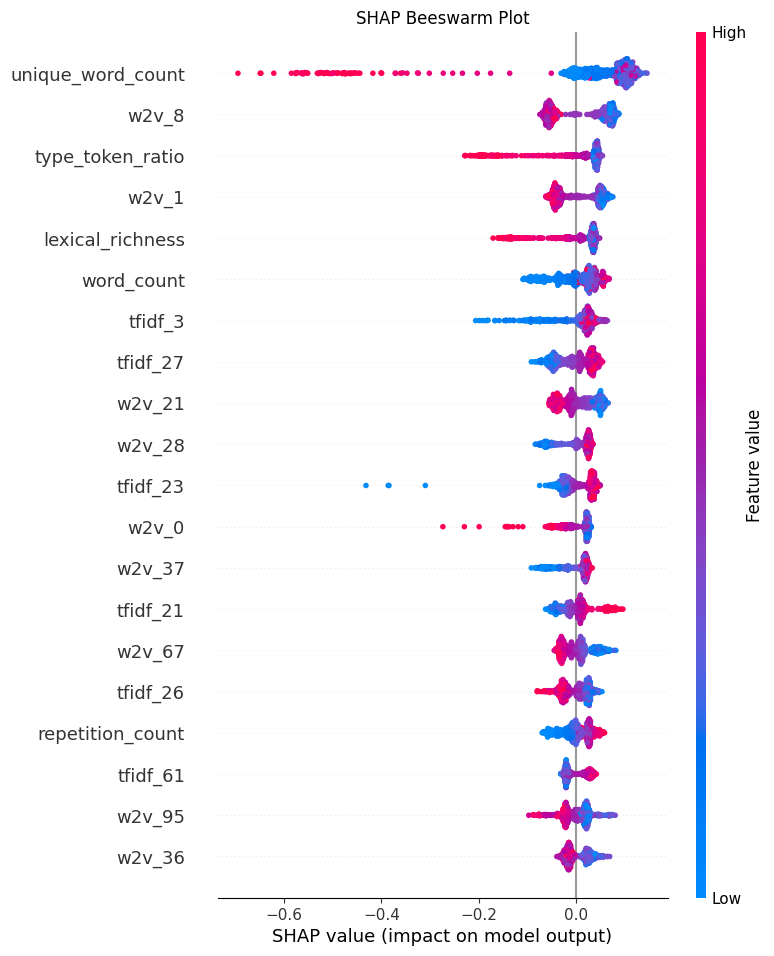

INFO: Generating feature importance bar plot...


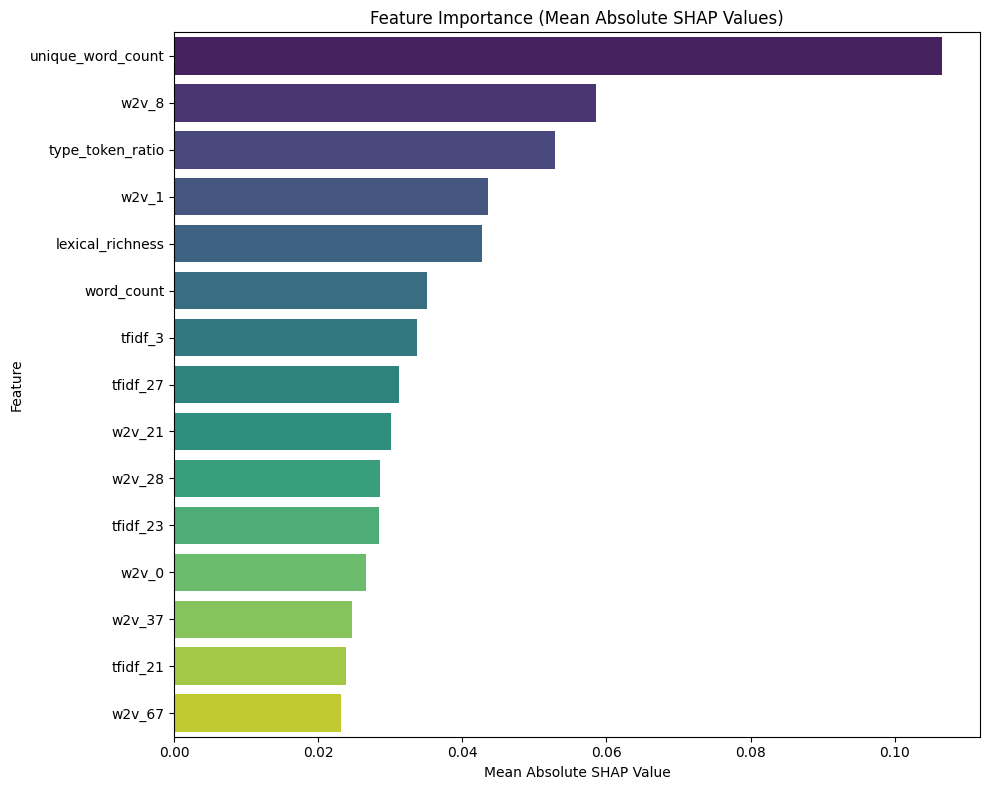

In [67]:
pipeline.perform_shap_analysis()

## Prediction with Spotify Features

In [123]:
target = 'popularity'
features = spotify_features

In [124]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [125]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'genre']

In [126]:
len(num_features)

11

In [127]:
pipeline = OptimalRegressionPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('preprocessor',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('num',
                                                                                                        Pipeline(steps=[('imputer',
                                                                                                                         SimpleImputer(strategy='median')),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['album_release_year',
                                                                                                         'energy',
                                                                                                         'speechiness',
                                                                                                         'loudness',
                                                                                                         'duration_ms',
                                                                                                         'danceability',
                                                                                                         'instrumen...
                                                                                                                                       strategy='constant')),
                                                                                                                        ('ordinal',
                                                                                                                         OrdinalEncoder(dtype='object',
                                                                                                                                        handle_unknown='use_encoded_value',
                                                                                                                                        unknown_value=-1))]),
                                                                                                        ['key',
                                                                                                         'explicit',
                                                                                                         'genre',
                                                                                                         'mode',
                                                                                                         'time_signature'])],
                                                                                         verbose_feature_names_out=False))])),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x7e07ed51b7f0>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [128]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-20 17:20:28,939] A new study created in RDB with name: catboost_optimization_24697dd3-81cd-46b7-917a-c51d0ad08ee3
[I 2024-12-20 17:20:42,301] Trial 1 finished with value: -0.21558390033067704 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.07968202478683421, 'l2_leaf_reg': 6.232580862750116}. Best is trial 1 with value: -0.21558390033067704.
[I 2024-12-20 17:20:42,816] Trial 7 finished with value: -0.2251456426986458 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.04034510632369607, 'l2_leaf_reg': 9.051372068204175}. Best is trial 1 with value: -0.21558390033067704.
[I 2024-12-20 17:20:42,927] Trial 3 finished with value: -0.21538658400550706 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.09534117553800472, 'l2_leaf_reg': 2.5642082567659754}. Best is trial 3 with value: -0.21538658400550706.
[I 2024-12-20 17:20:54,205] Trial 2 finished with value: -0.21711874148259908 and parameters: {'iterations': 1000, 'depth': 4, '

INFO: Pipeline training completed.


In [129]:
pipeline.model.training_results

,Metric,Score
0,MAE,0.351
1,MSE,0.210
2,RMSE,0.458
3,R2,0.790


INFO: Evaluating the regression model...


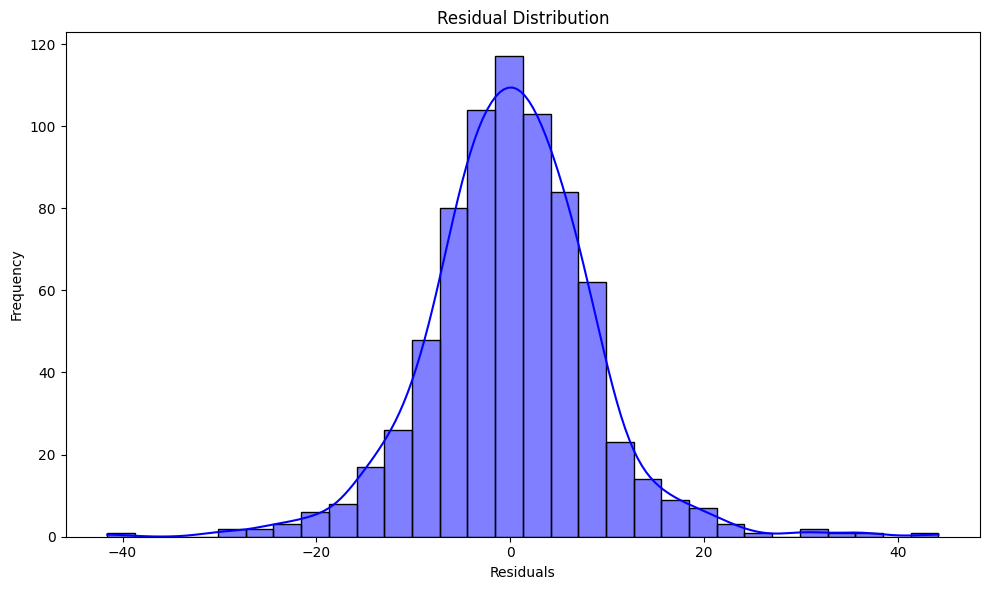

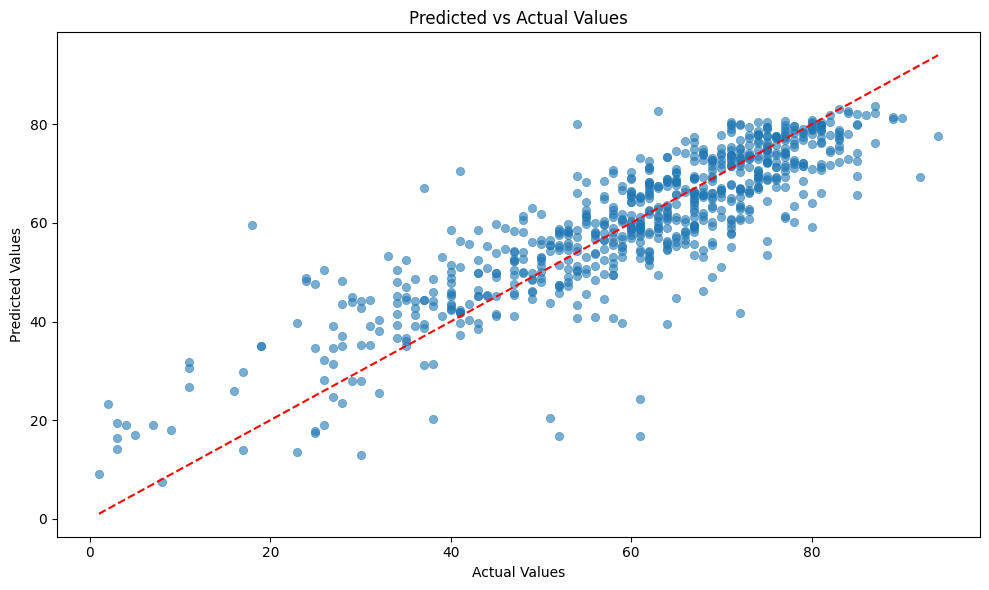

,Metric,Score
0,Mean Absolute Error,6.263727
1,Mean Squared Error,72.242961
2,Root Mean Squared Error,8.499586
3,R2 Score,0.744432


In [130]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


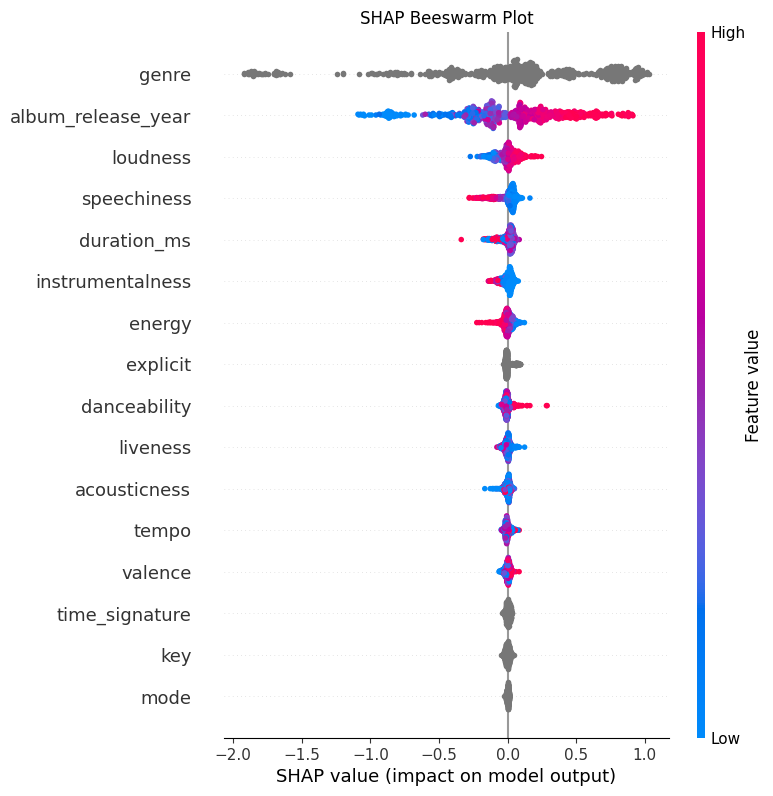

INFO: Generating feature importance bar plot...


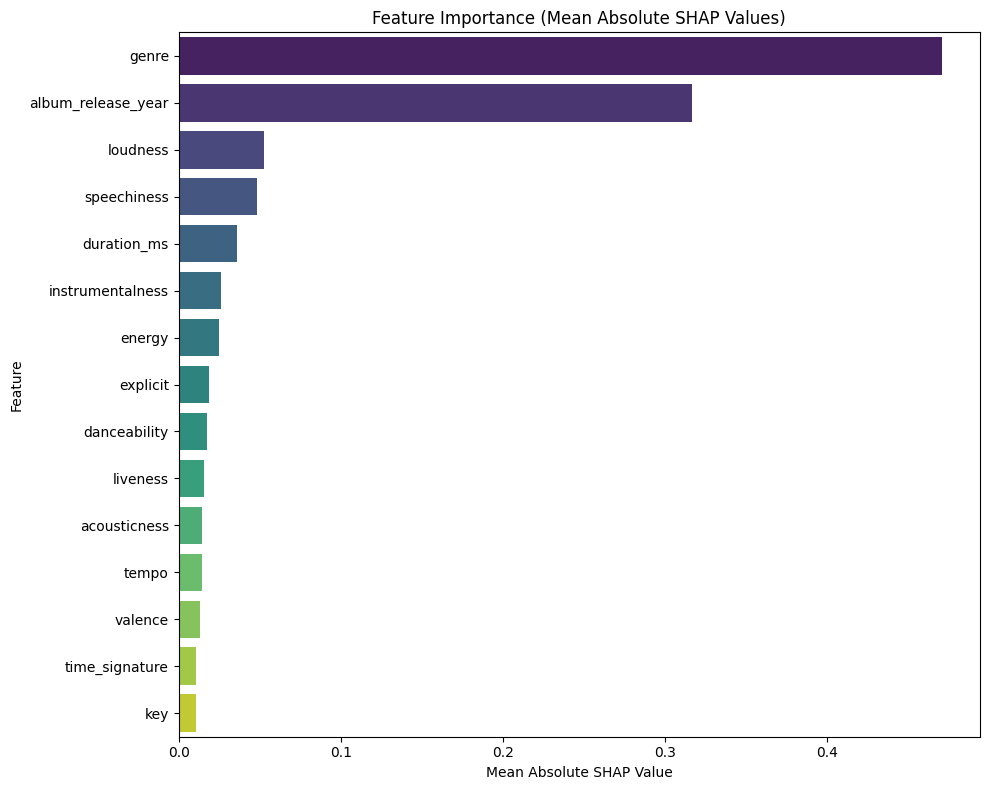

In [131]:
pipeline.perform_shap_analysis()

## Prediction with Audio Features

In [42]:
target = 'popularity'
features = audio_extracted_features

In [43]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [48]:
cat_features

[]

In [49]:
len(num_features)

34

In [70]:
pipeline = OptimalRegressionPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=[],
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('preprocessor',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('num',
                                                                                                        Pipeline(steps=[('imputer',
                                                                                                                         SimpleImputer(strategy='median')),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['chroma_8',
                                                                                                         'spectral_contrast_2',
                                                                                                         'mfcc_2',
                                                                                                         'mfcc_11',
                                                                                                         'chroma_6',
                                                                                                         'spectral_contrast_3',
                                                                                                         'chroma_5...
                                                                                                                         OrdinalEncoder(dtype='object',
                                                                                                                                        handle_unknown='use_encoded_value',
                                                                                                                                        unknown_value=-1))]),
                                                                                                        [])],
                                                                                         verbose_feature_names_out=False)),
                                                                      ('feature_selection',
                                                                       SelectFromModel(estimator=RandomForestRegressor(random_state=42),
                                                                                       threshold='mean'))])),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x71e2e6dccfa0>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [71]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-19 20:57:05,107] A new study created in RDB with name: catboost_optimization_3ca792e6-5d3f-4442-be13-b8655a9fe4fb
[I 2024-12-19 20:57:19,238] Trial 4 finished with value: -0.8573134619690235 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.04175898774990752, 'l2_leaf_reg': 4.9067170295623574}. Best is trial 4 with value: -0.8573134619690235.
[I 2024-12-19 20:57:30,386] Trial 7 finished with value: -0.9160996567820442 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.09628124526736671, 'l2_leaf_reg': 2.7006784572454885}. Best is trial 4 with value: -0.8573134619690235.
[I 2024-12-19 20:57:32,650] Trial 2 finished with value: -0.8730587496394318 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.04174572360706762, 'l2_leaf_reg': 1.7856288513220822}. Best is trial 4 with value: -0.8573134619690235.
[I 2024-12-19 20:57:53,828] Trial 9 finished with value: -0.9058536848602081 and parameters: {'iterations': 1000, 'depth': 4, 'le

INFO: Pipeline training completed.


In [74]:
pipeline.model.training_results

,Metric,Score
0,MAE,0.724
1,MSE,0.857
2,RMSE,0.926
3,R2,0.141


INFO: Evaluating the regression model...


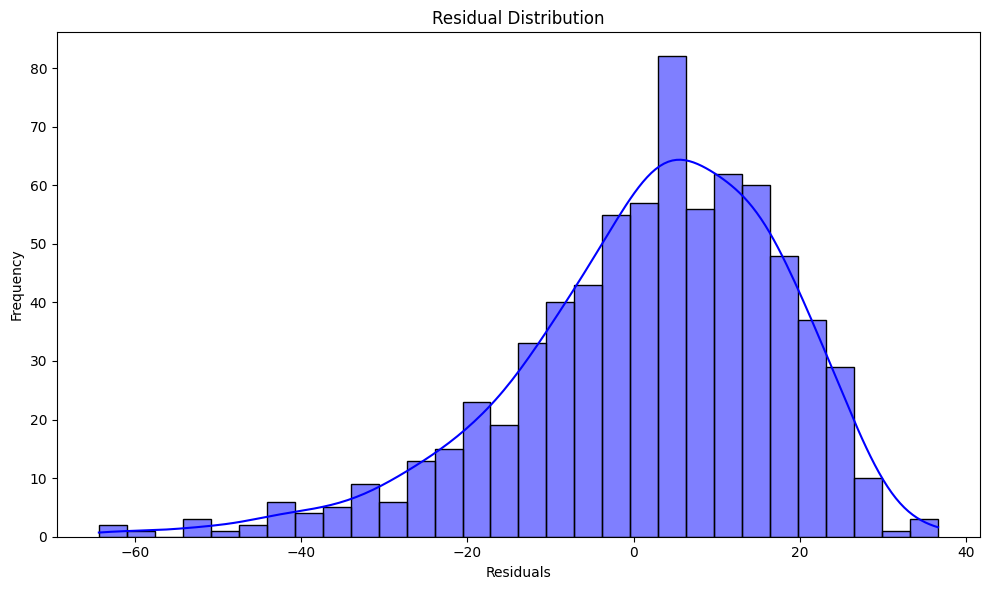

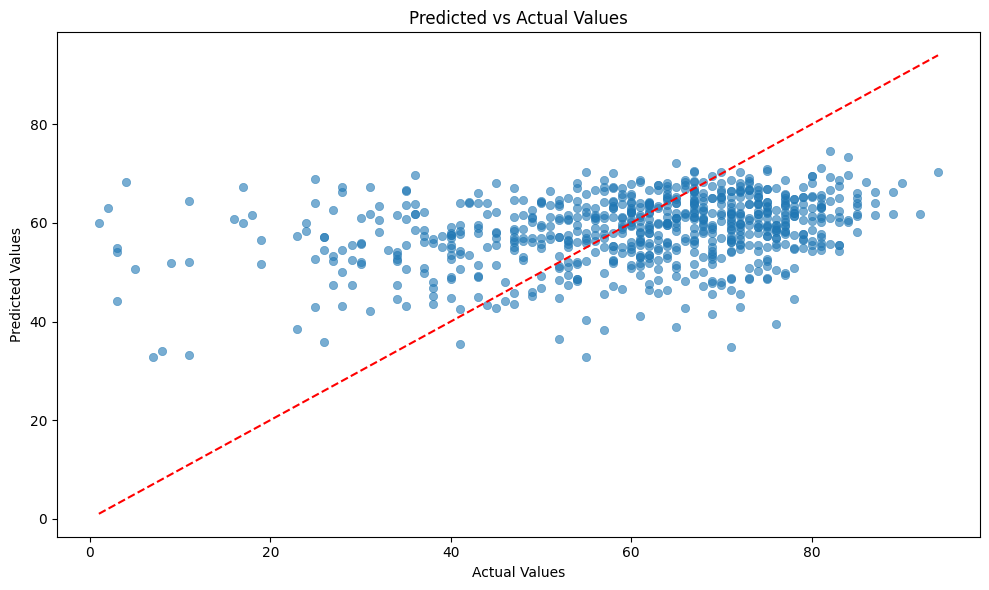

,Metric,Score
0,Mean Absolute Error,12.768907
1,Mean Squared Error,262.034195
2,Root Mean Squared Error,16.187470
3,R2 Score,0.073023


In [75]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


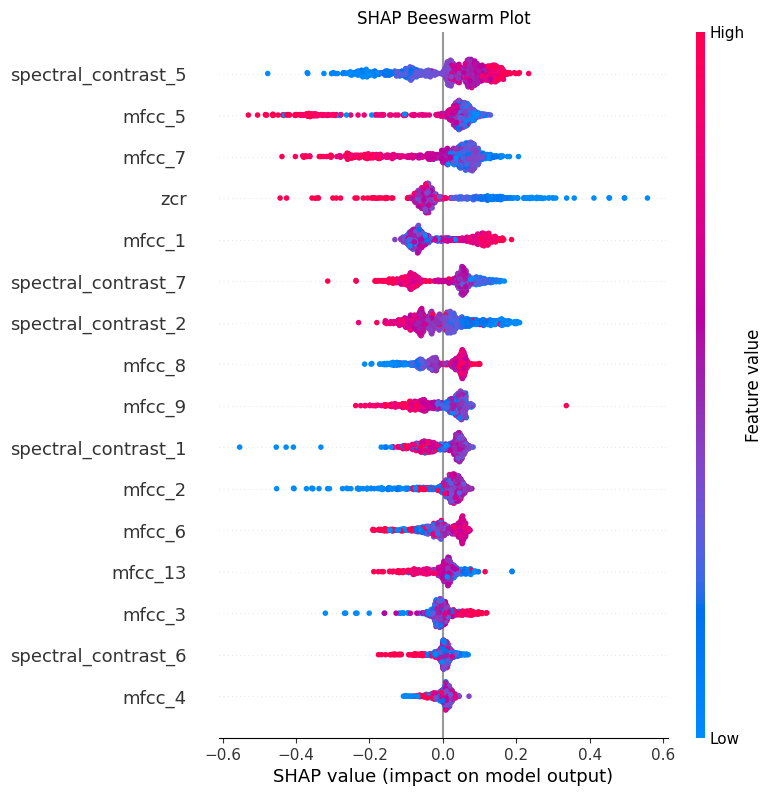

INFO: Generating feature importance bar plot...


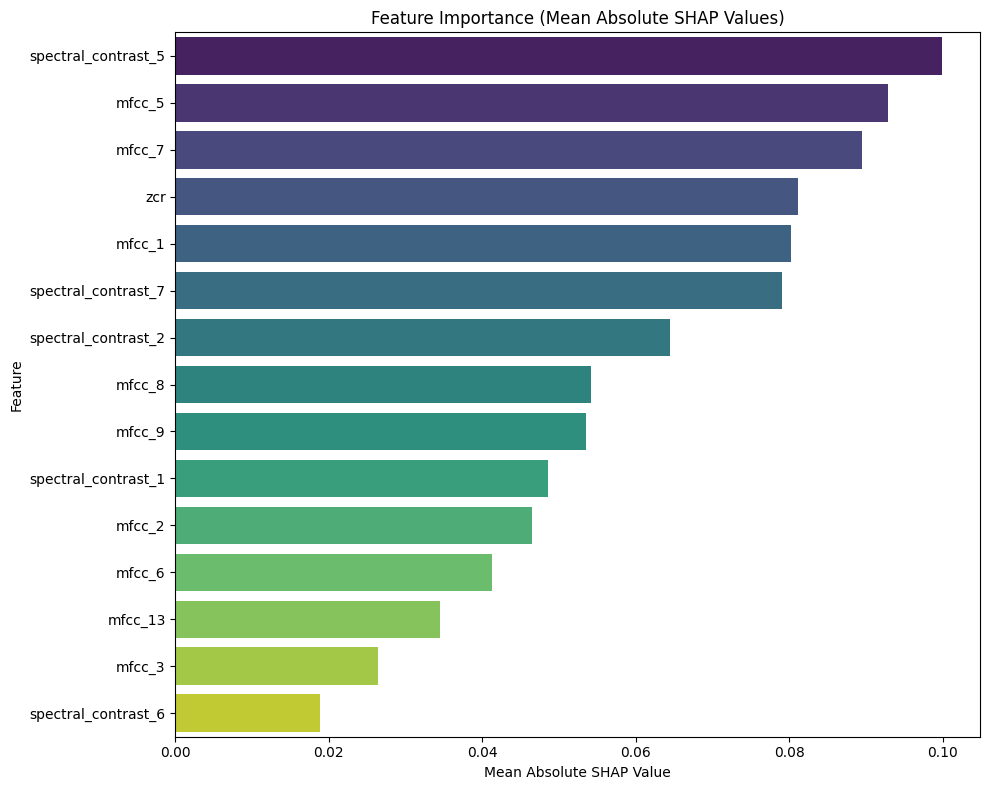

In [76]:
pipeline.perform_shap_analysis()

## Baseline

In [79]:
mean_model = MeanBaselineModel()
mean_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = mean_model.predict(pipeline.X_test)
mean_model.evaluate(pipeline.y_test, y_pred)

,Score
MAE,13.532726
MSE,285.647024
RMSE,16.901095
R2,-0.010510


# Classification

In [83]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")

Loaded 3621 songs


In [84]:
df['popularity_binary'] = df.popularity.apply(lambda x: x >= df.popularity.quantile(0.7)).astype(int)
df['popularity_binary'].value_counts()

popularity_binary
0    2464
1    1157
Name: count, dtype: int64

In [85]:
df.popularity.quantile(0.7)

70.0

In [86]:
df = df.drop('popularity', axis=1)

## Prediction with all features

In [10]:
target = 'popularity_binary'
features = [ f for f in spotify_features + lyrics_features + tfidf_features + w2v_features + empath_features + audio_extracted_features if f in df.columns ]

In [11]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [12]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'language', 'genre']

In [13]:
len(num_features)

457

In [14]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['flesch_reading_ease',
                                                                    'w2v_62',
                                                                    'empath_power',
                                                                    'tfidf_48',
                                                                    'empath_medieval',
                                                                    'empath_swearing_terms',
                                                                    'empath_musical',
                                                                    'tfidf_71',
                                                                    'tfi...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['key',
                                                                    'language',
                                                                    'explicit',
                                                                    'genre',
                                                                    'mode',
                                                                    'time_signature'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7e07f1780340>)])

In [15]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-20 00:28:29,062] Using an existing study with name 'catboost_popularity_binary' instead of creating a new one.
[I 2024-12-20 01:07:54,806] Trial 68 finished with value: 0.8666007877541398 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.05964373524130189, 'l2_leaf_reg': 8.346789896591073}. Best is trial 68 with value: 0.8666007877541398.
[I 2024-12-20 01:09:20,271] Trial 67 finished with value: 0.865562542637314 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.05896826253920046, 'l2_leaf_reg': 7.384807073482771}. Best is trial 68 with value: 0.8666007877541398.
[I 2024-12-20 01:10:26,928] Trial 71 finished with value: 0.862495435045027 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.05889049027215683, 'l2_leaf_reg': 7.584911834263518}. Best is trial 68 with value: 0.8666007877541398.
[I 2024-12-20 01:10:56,571] Trial 70 finished with value: 0.8644722640841275 and parameters: {'iterations': 1000, 'depth': 8, 'learning_

INFO: Pipeline training completed.


In [16]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.871
1,F1 Score,0.871
2,Precision,0.872
3,Recall,0.871


INFO: Evaluating the model...


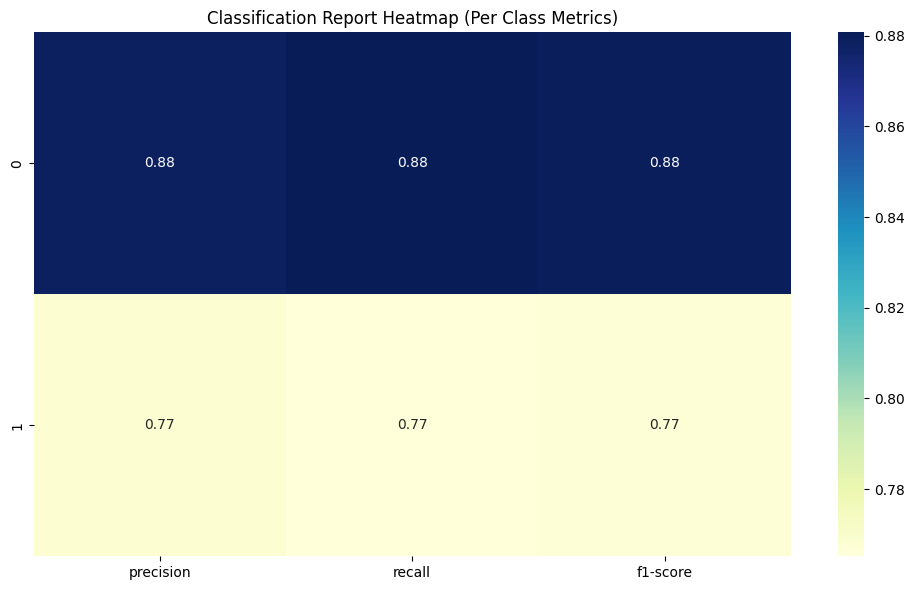

,precision,recall,f1-score,support
0,0.878914,0.880753,0.879833,478.000000
1,0.768293,0.765182,0.766734,247.000000
accuracy,0.841379,0.841379,0.841379,0.841379
macro avg,0.823604,0.822968,0.823284,725.000000
weighted avg,0.841227,0.841379,0.841301,725.000000


In [17]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


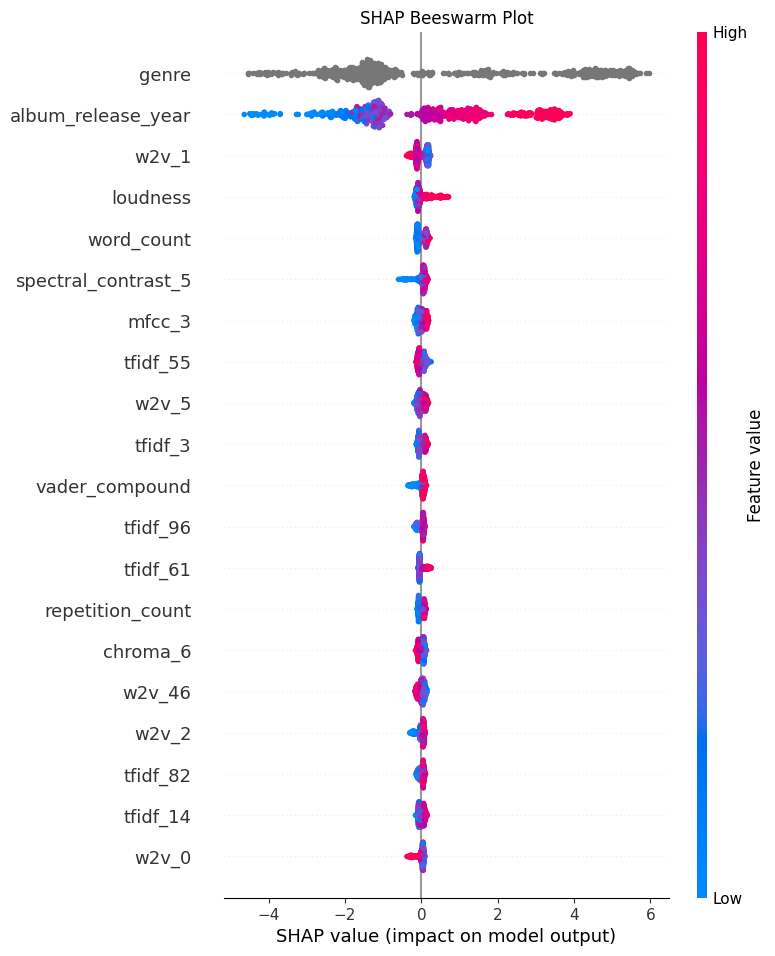

INFO: Generating feature importance bar plot...


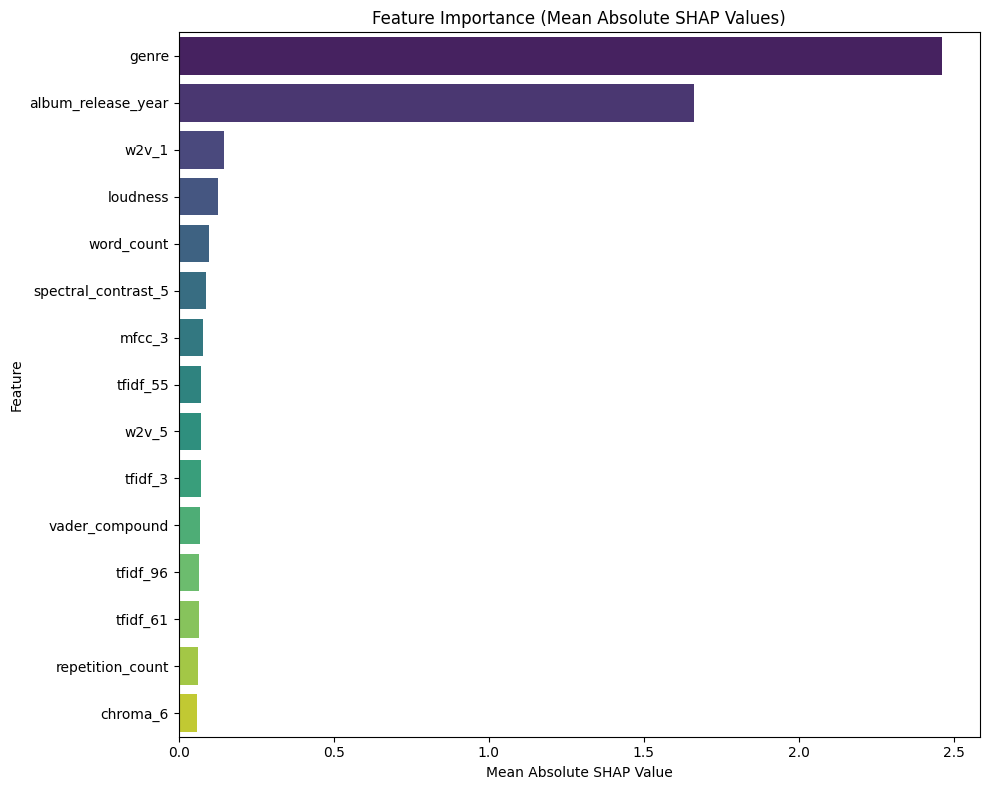

In [18]:
pipeline.perform_shap_analysis()

## Prediction with lyrics

In [87]:
target = 'popularity_binary'
features = [ f for f in lyrics_features + tfidf_features + w2v_features + empath_features if f in df.columns ]

In [88]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [89]:
cat_features

['language']

In [90]:
len(num_features)

412

In [91]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['flesch_reading_ease',
                                                                    'w2v_62',
                                                                    'empath_power',
                                                                    'tfidf_48',
                                                                    'empath_medieval',
                                                                    'empath_swearing_terms',
                                                                    'empath_musical',
                                                                    'tfidf_71',
                                                                    'tfi...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['language'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7e07ed0bfa60>)])

In [92]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-20 15:04:12,370] A new study created in RDB with name: catboost_popularity_binary
[I 2024-12-20 15:06:07,531] Trial 4 finished with value: 0.6650821708388437 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.09093041214077982, 'l2_leaf_reg': 3.584476546078476}. Best is trial 4 with value: 0.6650821708388437.
[I 2024-12-20 15:06:14,041] Trial 1 finished with value: 0.6733045685410497 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.02544369787387648, 'l2_leaf_reg': 2.4141930752490155}. Best is trial 1 with value: 0.6733045685410497.
[I 2024-12-20 15:07:58,948] Trial 3 finished with value: 0.67758130723461 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.05453049853217362, 'l2_leaf_reg': 5.00623656662634}. Best is trial 3 with value: 0.67758130723461.
[I 2024-12-20 15:08:04,513] Trial 7 finished with value: 0.6730800153519081 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.07667233012727365, 'l2_leaf_reg

INFO: Pipeline training completed.


In [93]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.687
1,F1 Score,0.679
2,Precision,0.676
3,Recall,0.687


INFO: Evaluating the model...


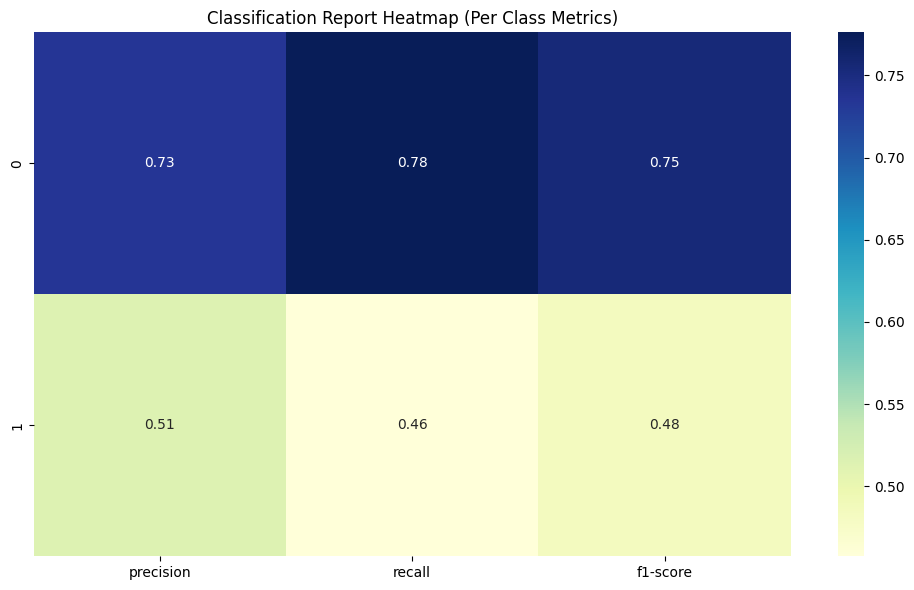

,precision,recall,f1-score,support
0,0.734653,0.776151,0.754832,478.000000
1,0.513636,0.457490,0.483940,247.000000
accuracy,0.667586,0.667586,0.667586,0.667586
macro avg,0.624145,0.616820,0.619386,725.000000
weighted avg,0.659355,0.667586,0.662542,725.000000


In [94]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


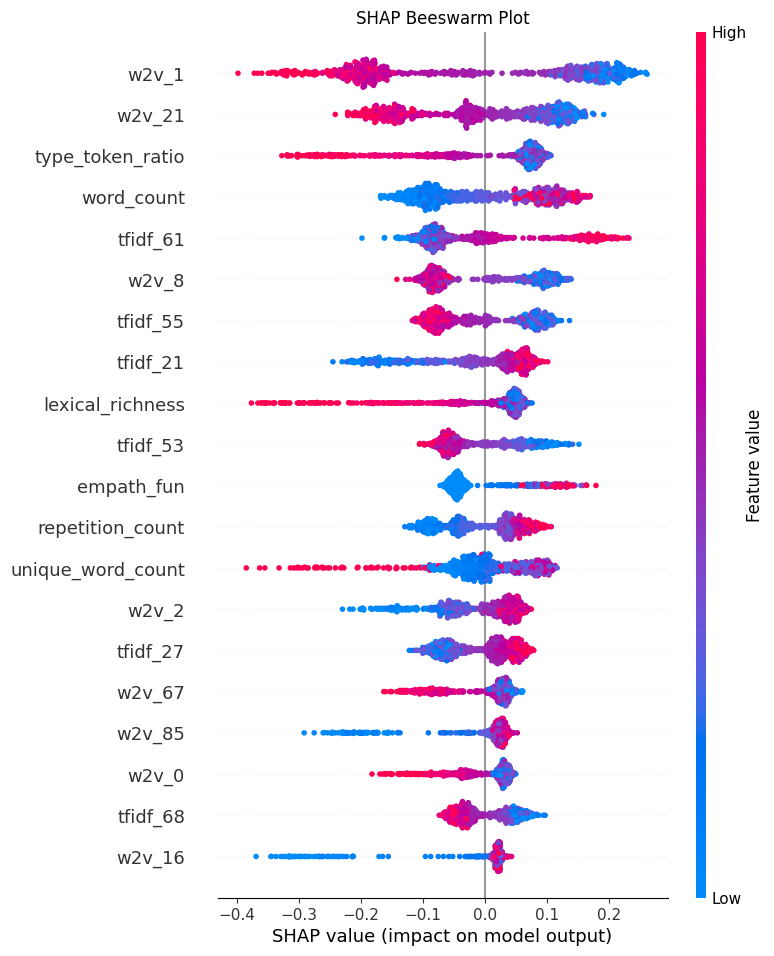

INFO: Generating feature importance bar plot...


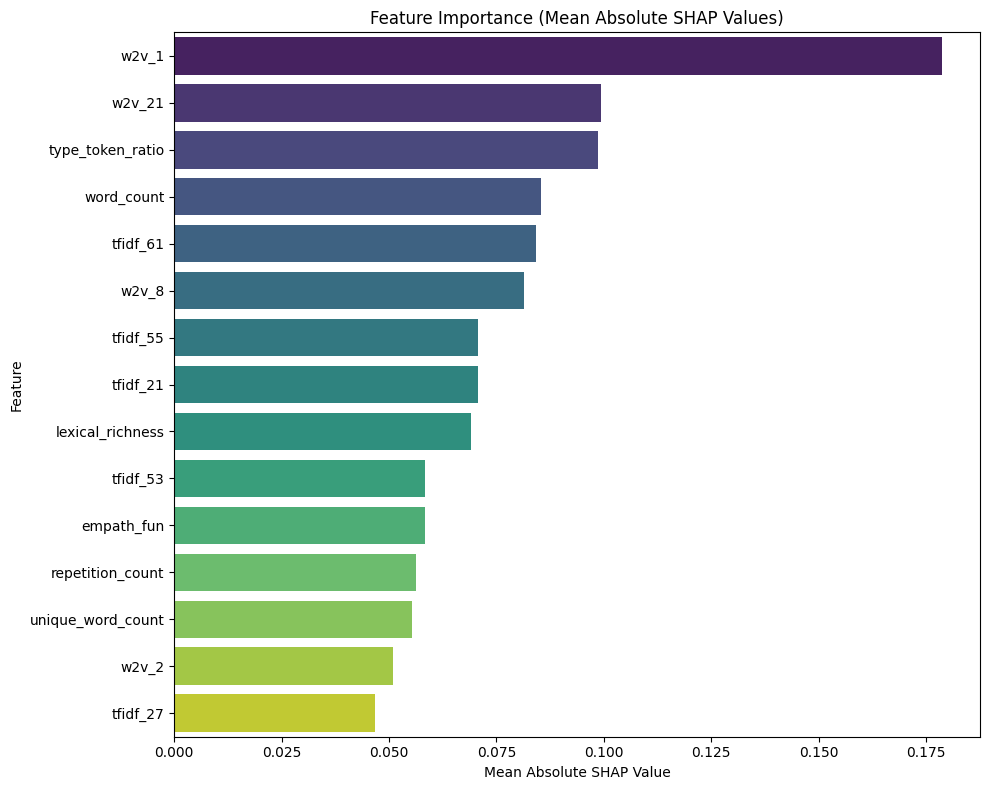

In [95]:
pipeline.perform_shap_analysis()

## Prediction with Spotify Features

In [96]:
target = 'popularity_binary'
features = [ f for f in spotify_features if f in df.columns ]

In [97]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [98]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'genre']

In [99]:
len(num_features)

11

In [100]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['album_release_year',
                                                                    'energy',
                                                                    'speechiness',
                                                                    'loudness',
                                                                    'duration_ms',
                                                                    'danceability',
                                                                    'instrumentalness',
                                                                    'liveness',
                                                                    'tempo',
                                                                    'acoustic...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['key',
                                                                    'explicit',
                                                                    'genre',
                                                                    'mode',
                                                                    'time_signature'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7e07efafd570>)])

In [101]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-20 15:13:07,381] Using an existing study with name 'catboost_popularity_binary' instead of creating a new one.
[I 2024-12-20 15:13:27,750] Trial 12 finished with value: 0.8561683182984504 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.014996030284805048, 'l2_leaf_reg': 7.544907013455134}. Best is trial 12 with value: 0.8561683182984504.
[I 2024-12-20 15:13:28,196] Trial 11 finished with value: 0.8559109256481001 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.01209629975806979, 'l2_leaf_reg': 7.7349237968120725}. Best is trial 12 with value: 0.8561683182984504.
[I 2024-12-20 15:13:28,224] Trial 10 finished with value: 0.8586628086641829 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.011211110314802238, 'l2_leaf_reg': 7.790034998169798}. Best is trial 10 with value: 0.8586628086641829.
[I 2024-12-20 15:13:28,738] Trial 14 finished with value: 0.8560934088540172 and parameters: {'iterations': 500, 'depth': 8, 'learning

INFO: Pipeline training completed.


In [102]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.858
1,F1 Score,0.861
2,Precision,0.867
3,Recall,0.858


INFO: Evaluating the model...


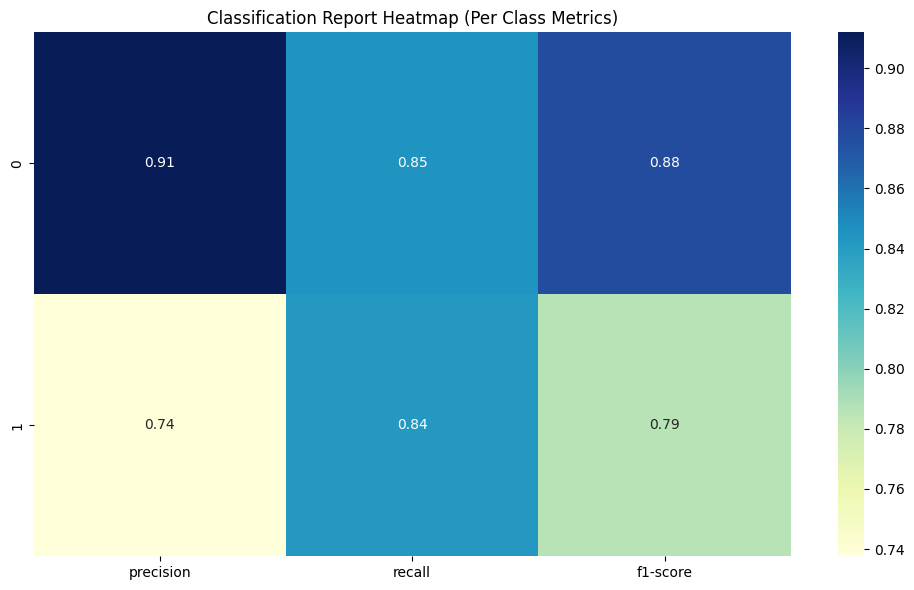

,precision,recall,f1-score,support
0,0.911964,0.845188,0.877307,478.000000
1,0.737589,0.842105,0.786389,247.000000
accuracy,0.844138,0.844138,0.844138,0.844138
macro avg,0.824776,0.843647,0.831848,725.000000
weighted avg,0.852556,0.844138,0.846333,725.000000


In [103]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


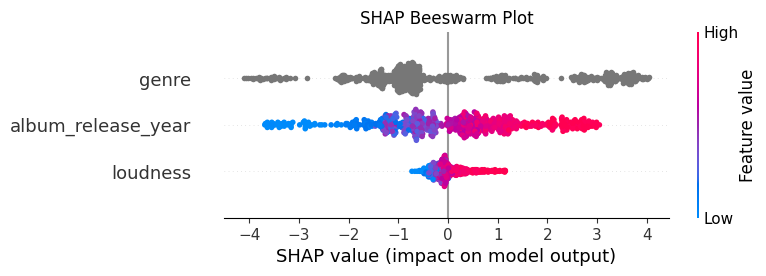

INFO: Generating feature importance bar plot...


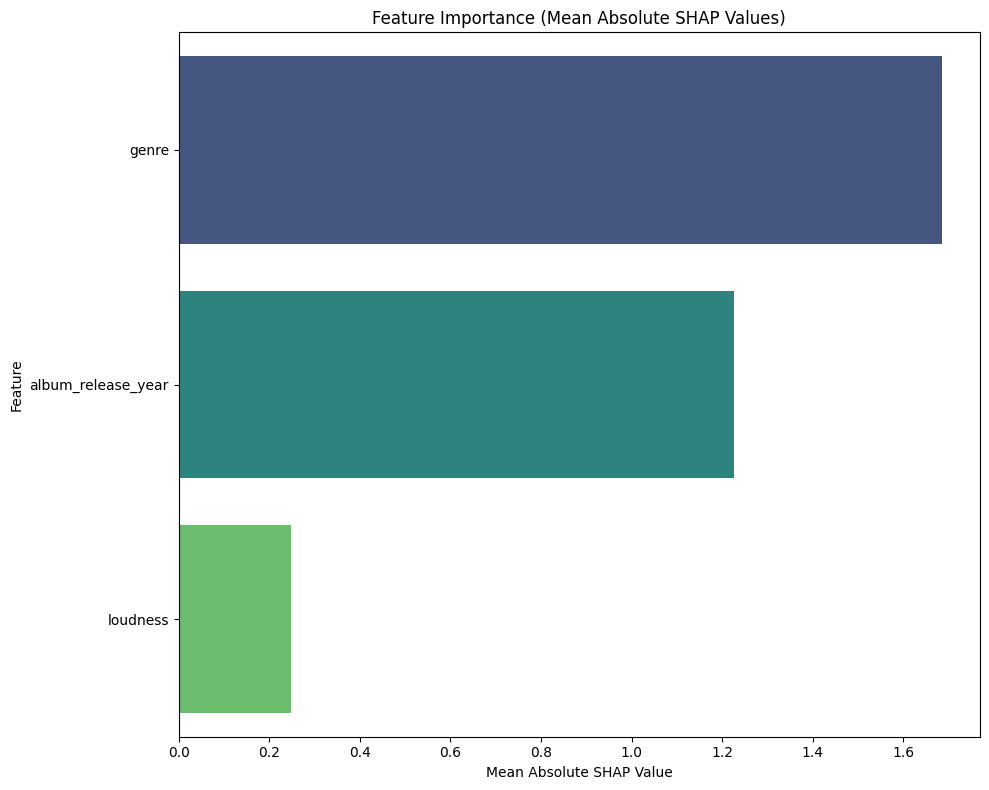

In [104]:
pipeline.perform_shap_analysis()

## Prediction with Audio Features

In [40]:
target = 'popularity_binary'
features = [ f for f in audio_extracted_features if f in df.columns ]

In [41]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [42]:
cat_features

[]

In [43]:
len(num_features)

34

In [44]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: popularity_binary
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['chroma_8',
                                                                    'mfcc_8',
                                                                    'mfcc_6',
                                                                    'spectral_contrast_2',
                                                                    'chroma_10',
                                                                    'spectral_contrast_6',
                                                                    'mfcc_3',
                                                                    'spectral_contrast_3',
                                                                    'zcr',
                                                                    'mfcc_7',...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   [])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7e07ed101ff0>)])

In [45]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-20 02:37:33,193] Using an existing study with name 'catboost_popularity_binary' instead of creating a new one.
[I 2024-12-20 02:39:21,386] Trial 99 finished with value: 0.6652266260828199 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.03992124748150304, 'l2_leaf_reg': 6.873196100475999}. Best is trial 73 with value: 0.8694160451077904.
[I 2024-12-20 02:39:23,223] Trial 100 finished with value: 0.6671446484597517 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.05609305697569284, 'l2_leaf_reg': 5.77325458621102}. Best is trial 73 with value: 0.8694160451077904.
[I 2024-12-20 02:39:23,886] Trial 96 finished with value: 0.6625216399811055 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.056427448277800746, 'l2_leaf_reg': 5.6475141956836294}. Best is trial 73 with value: 0.8694160451077904.
[I 2024-12-20 02:39:23,932] Trial 101 finished with value: 0.6724994694355255 and parameters: {'iterations': 1000, 'depth': 8, 'lear

INFO: Pipeline training completed.


In [46]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.678
1,F1 Score,0.671
2,Precision,0.666
3,Recall,0.678


INFO: Evaluating the model...


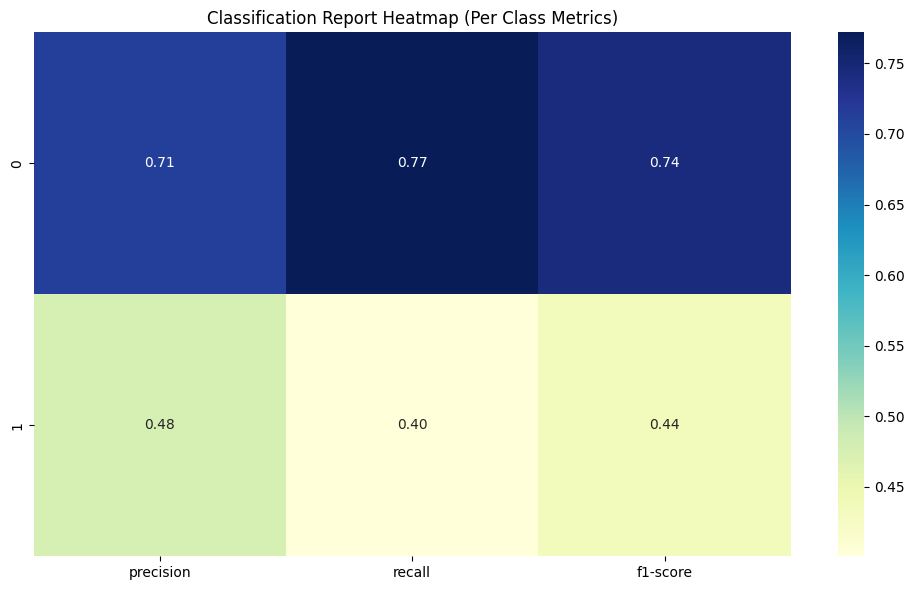

,precision,recall,f1-score,support
0,0.713733,0.771967,0.741709,478.000000
1,0.475962,0.400810,0.435165,247.000000
accuracy,0.645517,0.645517,0.645517,0.645517
macro avg,0.594847,0.586388,0.588437,725.000000
weighted avg,0.632727,0.645517,0.637272,725.000000


In [47]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


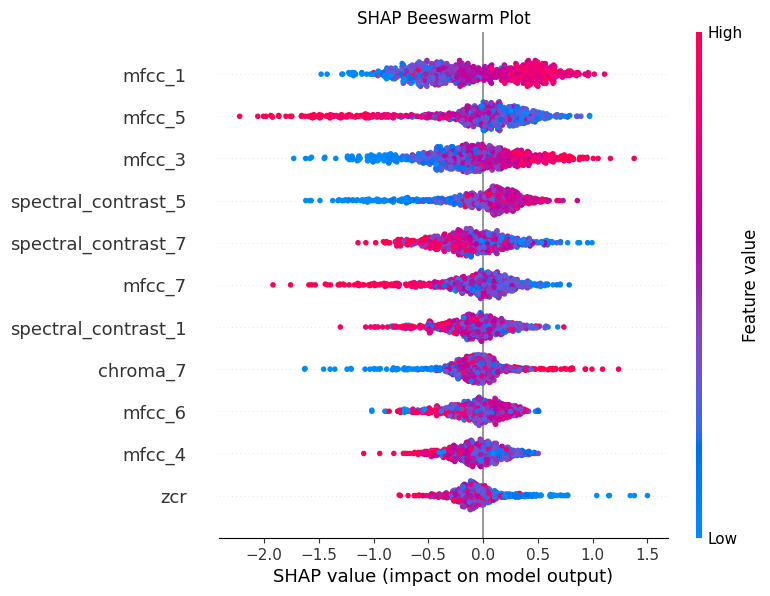

INFO: Generating feature importance bar plot...


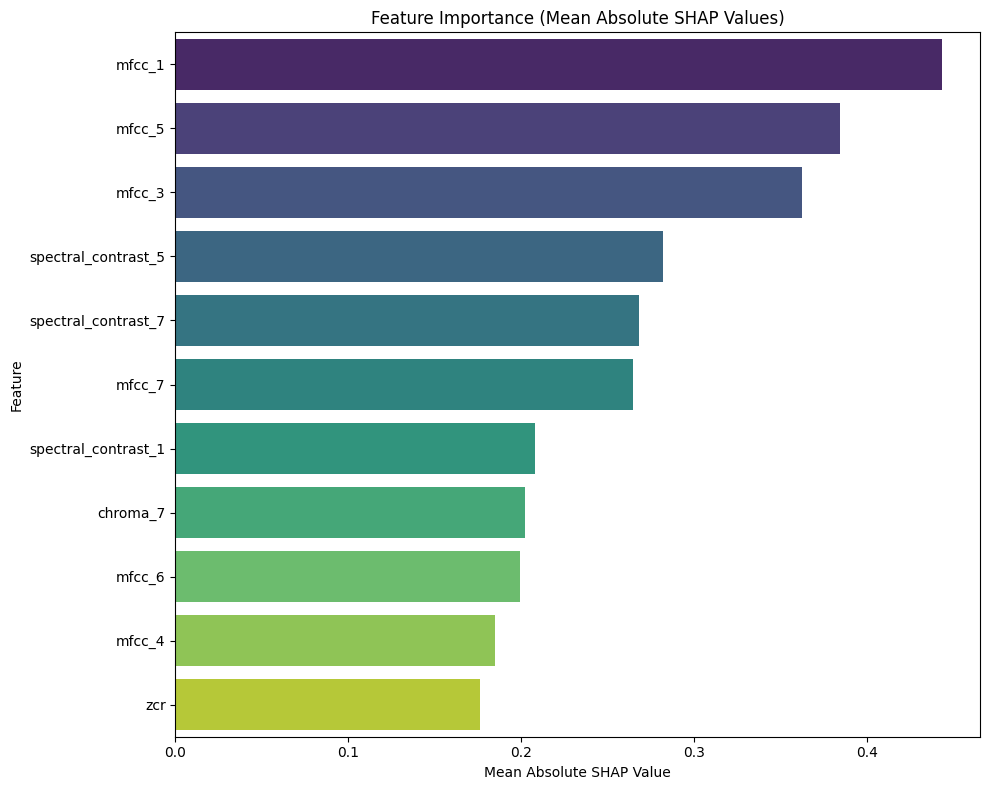

In [48]:
pipeline.perform_shap_analysis()

## Baseline

In [49]:
majority_model = MajorityBaselineModel()
majority_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = majority_model.predict(pipeline.X_test)
majority_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.659310
Precision,0.434690
Recall,0.659310
F1 Score,0.523941


In [50]:
random_model = RandomBaselineModel()
random_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = random_model.predict(pipeline.X_test)
random_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.513103
Precision,0.562739
Recall,0.513103
F1 Score,0.525791
